In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

In [3]:
data_path = 'final_merged_base_alberta_wildfire_with_gas_and_pipes_summary.csv'
df = pd.read_csv(data_path)
df['Year'] = pd.to_datetime(df['Month']).dt.year
df['Month'] = pd.to_datetime(df['Month']).dt.month

df.to_csv('debug1.csv', index=False)


features = [
    'A', 'B', 'C', 'D', 'E',
    'Year', 'Month',
    'Gas Plant Frac', 
    'Gas Plant Sweet',
    'Gp Acid Gas Flaring',
    'Gp Acid Gas Flaring%', 
    'Gp Acid Gas Inj',
    'Gp Mainline Strdle', 
    'Gp Sulphur Rcvry', 
    'Avg Capacity (1000 m3/d)'
]

for feature in features:
    if df[feature].dtype == object: 
        df[feature] = df[feature].str.replace(',', '').astype(float)



In [4]:
train_df = df[(df['Year'] < 2018) | ((df['Year'] == 2018) & (df['Month'] <= 10))]
test_df = df[((df['Year'] == 2018) & (df['Month'] >= 11)) | (df['Year'] > 2018)]

print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

Training set shape: (141, 18)
Testing set shape: (36, 18)


In [5]:
X_train = train_df[features]
y_train = train_df['prod_%_diff']
X_test = test_df[features]
y_test = test_df['prod_%_diff']

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

xgb_model = XGBRegressor(objective ='reg:squarederror', random_state=42)
cat_model = CatBoostRegressor(silent=True,random_state=42)
lgbm_model = LGBMRegressor(random_state=42)
rfc_model = RandomForestRegressor(n_estimators=100, random_state=42)

xgb_model.fit(X_train_scaled, y_train)
cat_model.fit(X_train_scaled, y_train)
lgbm_model.fit(X_train_scaled, y_train)
rfc_model.fit(X_train_scaled, y_train) 

xgb_pred = xgb_model.predict(X_test_scaled)
cat_pred = cat_model.predict(X_test_scaled)
lgbm_pred = lgbm_model.predict(X_test_scaled)
rfc_pred = rfc_model.predict(X_test_scaled) 

xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

cat_mse = mean_squared_error(y_test, cat_pred)
cat_r2 = r2_score(y_test, cat_pred)

lgbm_mse = mean_squared_error(y_test, lgbm_pred)
lgbm_r2 = r2_score(y_test, lgbm_pred)

rfc_mse = mean_squared_error(y_test, rfc_pred)
rfc_r2 = r2_score(y_test, rfc_pred)

C:\Users\gjftn\AppData\Roaming\Python\Python310\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\gjftn\AppData\Roaming\Python\Python310\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\gjftn\AppData\Roaming\Python\Python310\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 308
[LightGBM] [Info] Number of data points in the train set: 141, number of used features: 13
[LightGBM] [Info] Start training from score -0.049826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [6]:
"""
ensemble_pred = np.mean([xgb_pred, cat_pred, lgbm_pred, rfc_pred], axis=0)
ensemble_mse = mean_squared_error(y_test, ensemble_pred)
ensemble_r2 = r2_score(y_test, ensemble_pred)
print(f"Ensemble - Mean Squared Error: {ensemble_mse}")
print(f"Ensemble - R-squared Value: {ensemble_r2}")
"""


'\nensemble_pred = np.mean([xgb_pred, cat_pred, lgbm_pred, rfc_pred], axis=0)\nensemble_mse = mean_squared_error(y_test, ensemble_pred)\nensemble_r2 = r2_score(y_test, ensemble_pred)\nprint(f"Ensemble - Mean Squared Error: {ensemble_mse}")\nprint(f"Ensemble - R-squared Value: {ensemble_r2}")\n'

In [7]:

print(f"XGBoost - MSE: {xgb_mse}, R-squared: {xgb_r2}")
print(f"CatBoost - MSE: {cat_mse}, R-squared: {cat_r2}")
print(f"LGBM - MSE: {lgbm_mse}, R-squared: {lgbm_r2}")
print(f"Random Forest - MSE: {rfc_mse}, R-squared: {rfc_r2}") 

XGBoost - MSE: 11.824041060058235, R-squared: 0.6992448882346496
CatBoost - MSE: 13.893317274827854, R-squared: 0.6466109878544564
LGBM - MSE: 16.555471701787017, R-squared: 0.5788966972705583
Random Forest - MSE: 10.154188665999724, R-squared: 0.741719084734457


In [8]:
baseline_features = ['Year', 'Month']
X_baseline = df[baseline_features]
y_baseline = df['prod_%_diff']
X_train_baseline, X_test_baseline = X_train[baseline_features], X_test[baseline_features]


sc_baseline = StandardScaler()


X_train_baseline_scaled = sc_baseline.fit_transform(X_train_baseline)
X_test_baseline_scaled = sc_baseline.transform(X_test_baseline)

models = {
    #"Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    #"XGBoost": XGBRegressor(objective='reg:squarederror', random_state=42),
    "LightGBM": LGBMRegressor(random_state=42),
    #"CatBoost": CatBoostRegressor(silent=True, random_state=42)
}

for name, model in models.items():
    model.fit(X_train_baseline_scaled, y_train)
    y_pred_baseline = model.predict(X_test_baseline_scaled)
    mse_baseline = mean_squared_error(y_test, y_pred_baseline)
    r2_baseline = r2_score(y_test, y_pred_baseline)
    print(f"{name} - Baseline Mean Squared Error: {mse_baseline}")
    print(f"{name} - Baseline R-squared Value: {r2_baseline}\n")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 141, number of used features: 2
[LightGBM] [Info] Start training from score -0.049826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [9]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def get_oof_predictions(model, X_train, y_train):
    return cross_val_predict(model, X_train, y_train, cv=kf, method='predict')

xgb_oof_pred = get_oof_predictions(xgb_model, X_train_scaled, y_train)
cat_oof_pred = get_oof_predictions(cat_model, X_train_scaled, y_train)
lgbm_oof_pred = get_oof_predictions(lgbm_model, X_train_scaled, y_train)
rfc_oof_pred = get_oof_predictions(rfc_model, X_train_scaled, y_train)


C:\Users\gjftn\AppData\Roaming\Python\Python310\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 270
[LightGBM] [Info] Number of data points in the train set: 112, number of used features: 13
[LightGBM] [Info] Start training from score 0.403686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [10]:
meta_features = np.column_stack((xgb_oof_pred, cat_oof_pred, lgbm_oof_pred, rfc_oof_pred))
meta_model = LinearRegression()
meta_model.fit(meta_features, y_train)

LinearRegression()

In [11]:
test_meta_features = np.column_stack((xgb_pred, cat_pred, lgbm_pred, rfc_pred))
final_predictions = meta_model.predict(test_meta_features)

In [12]:
ensemble_mse = mean_squared_error(y_test, final_predictions)
ensemble_r2 = r2_score(y_test, final_predictions)

print(f"Ensemble - Mean Squared Error: {ensemble_mse}")
print(f"Ensemble - R-squared Value: {ensemble_r2}")


Ensemble - Mean Squared Error: 11.729984083869548
Ensemble - R-squared Value: 0.7016373119620583


C:\Users\gjftn\AppData\Local\Temp\ipykernel_21744\2221118708.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Date'] = pd.to_datetime(test_df[['Year', 'Month']].assign(DAY=1))


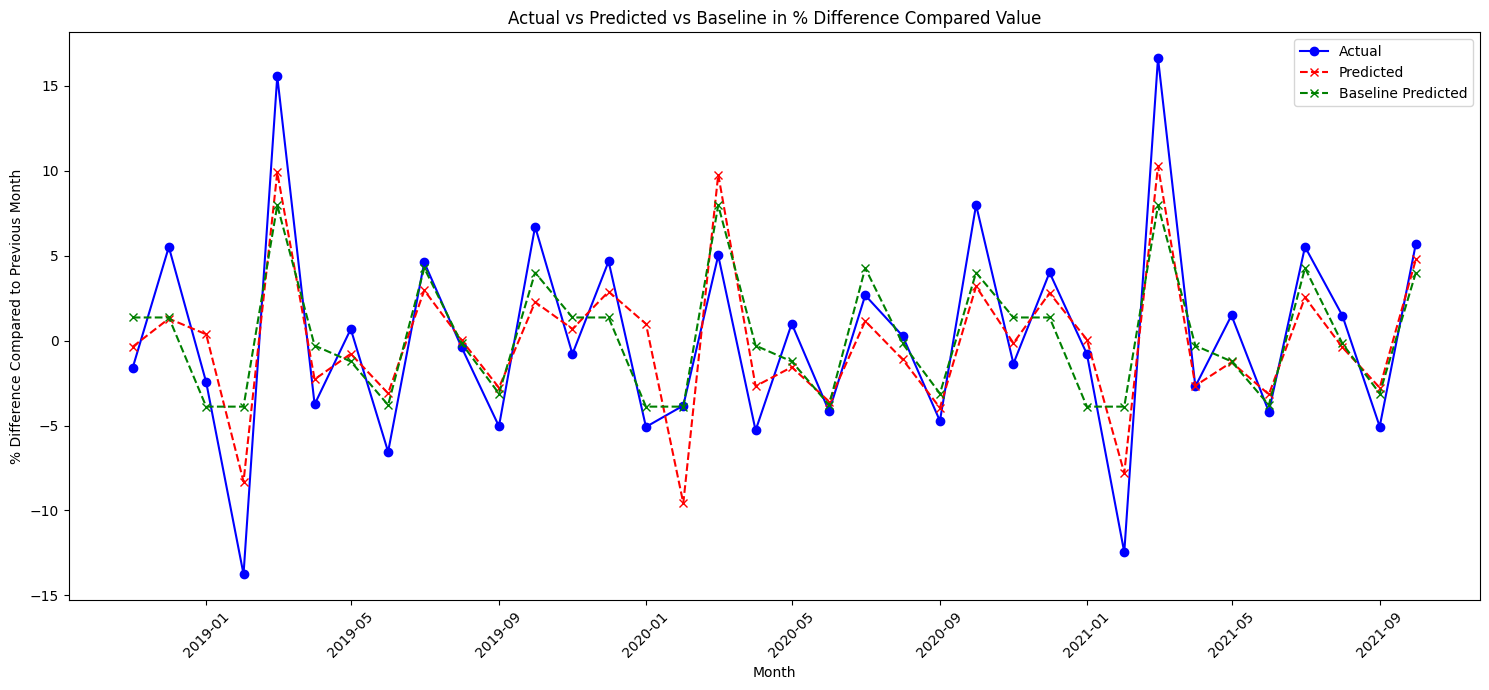

In [13]:
test_df['Date'] = pd.to_datetime(test_df[['Year', 'Month']].assign(DAY=1))
test_df = test_df.sort_values(by='Date')

y_pred_aligned = rfc_model.predict(X_test_scaled)
plot_df = pd.DataFrame({
    'Date': test_df['Date'],
    'Actual': y_test,
    'Predicted': y_pred_aligned
})


plt.figure(figsize=(15, 7))
plt.plot(plot_df['Date'], plot_df['Actual'], label='Actual', marker='o', linestyle='-', color='blue')
plt.plot(plot_df['Date'], plot_df['Predicted'], label='Predicted', marker='x', linestyle='--', color='red')
plt.plot(plot_df['Date'], y_pred_baseline, label='Baseline Predicted', marker='x', linestyle='--', color='green')

plt.title('Actual vs Predicted vs Baseline in % Difference Compared Value')
plt.xlabel('Month')
plt.ylabel('% Difference Compared to Previous Month')
plt.xticks(rotation=45) 
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
data = {'Month': [2], 'Year': [2024]}
demo_df = pd.DataFrame(data)

for feature in features:
    if feature not in demo_df.columns:
        demo_df[feature] = 0 

for feature in features:
    demo_df[feature] = demo_df[feature].astype(float)

X_demo_scaled = sc.transform(demo_df[features])

xgb_demo_pred = xgb_model.predict(X_demo_scaled)
cat_demo_pred = cat_model.predict(X_demo_scaled)
lgbm_demo_pred = lgbm_model.predict(X_demo_scaled)
rfc_demo_pred = rfc_model.predict(X_demo_scaled)

print(f"XGBoost Demo Prediction: {xgb_demo_pred[0]}")
print(f"CatBoost Demo Prediction: {cat_demo_pred[0]}")
print(f"LGBM Demo Prediction: {lgbm_demo_pred[0]}")
print(f"Random Forest Demo Prediction: {rfc_demo_pred[0]}")

XGBoost Demo Prediction: -9.70965576171875
CatBoost Demo Prediction: -7.687923857441697
LGBM Demo Prediction: -4.186289275181612
Random Forest Demo Prediction: -9.494537785429998
